### Soluzione esatta

## Formulazione debole e sua approssimazione

Prendiamo l'equazione e moltiplichiamola per ogni $t>0$ per una funzione test $v=v(x)$ integrando su $\Omega$.
Lo spazio di funzioni test $V$ è lo spazio di funzioni $H^1(\Omega)$ che si annullano in $x_{min}$ e 1.

L'equazione diventa:

$$\int_{\Omega} \dot{u(t)}v\, d\Omega + a(u(t),v) = 0$$

dove

$$a(u,v) = \int_{\Omega} \left(\mu u' - b u\right)v'\, d\Omega,$$

con il punto che indica la derivata temporale, l'apostrofo la derivata spaziale.

L'approssimazione di Galerkin del problema si ottiene scegliendo in uno spazio $V_h \subset V$ a dimensione finita $N_h$ una base $\{\phi_j\}$:

$$u_h(x,t) = \sum_{j=1}^{N_h} u_j(t)\phi_j(x)$$

così che l'equazione in forma debole diventa

$$\sum_{j=1}^{N_h}\left(
    \dot{u}_j(t) \int_{\Omega} \phi_j \phi_i\, d\Omega + u_j(t) a(\phi_j,\phi_i) = 0
\right)$$

ovvero, definendo il vettore delle incognite $\mathbf{u} = (u_1(t), \dots,u_{N_h}(t))^T$, la matrice di massa $M = [\int_{\Omega} \phi_j \phi_i\,d\Omega]$ e la matrice di rigidezza $A = [a(\phi_j,\phi_i)]$ il sistema può essere riscritto nella forma

$$M\dot{\mathbf{u}(t)} + A\mathbf{u}(t) = 0$$

Discretizziamo l'equazione con il metodo di Crank-Nicolson:

$$M\frac{\mathbf{u}^{k+1}-\mathbf{u}^k}{\Delta t} + \frac{1}{2}A(\mathbf{u}^{k+1}+\mathbf{u}^k) = 0.$$

Il sistema da risolvere è:

$$K\mathbf{u}^{k+1} = \mathbf{g}$$

dove $K = M/\Delta t + A/2$, $\mathbf{g} = (M/\Delta t - A/2)\mathbf{u}^k$.

Moltiplica per delta t

In [ ]:
ndof = 1# grado degli elementi finiti
fe = FE(ndof)
N = 100
rmin = 1e-1 #raggio minimo
alpha = 1 # nu = Ar^alpha
 
a, b = rmin, 1
griglia = GRID(a,b,N,ndof=ndof,getM=True,fe=fe)


A = getA(fe,griglia,adisc,constantdiffusion=False)

dt = 10
t = 0
eps = (b-a)/50
Nsteps = 1000

f0 = lambda x: nicekernel(x,(b+a)/2,eps)
X = griglia.globV
u = f0(X)
ts = []
fig, ax = plt.subplots()
# ax.plot(X,u/X,label="initial")

errs = np.array([])
for i in tqdm(range(Nsteps)):
    t+=dt
    ts = np.append(ts,t)
    u = advance(u,dt,griglia.M,A)
ax.plot(X,u,label="final")

grigliaconv = GRID((b+a)/2-2*eps,(b+a)/2+2*eps,10)
Y = discexact(X,t/1000,f0,grigliaconv,approx=True)
sigma = Y
ax.plot(X,sigma,label="exact")
ax.legend()

plt.show()

### Debugging forma quadratica analitica $\alpha=0$

In [ ]:
ndof = 1# grado degli elementi finiti
fe = FE(ndof)
N = 100
rmin = 10 #raggio minimo 
rmax = 100
alpha = 0 # nu = Ar^alpha
 
a, b = rmin, rmax
griglia = GRID(a,b,N,ndof=ndof,getM=True,fe=fe)

def adisc(u,v,du,dv,xL=0,dx=1):
    #v in realtà non viene usata ma almeno c'è chiarezza
    mu = lambda r: r**alpha
    # mu = lambda r: 0
    b = lambda r: -(alpha-1/2)*r**(alpha-1)
    # b = lambda r: 0
    xrest = lambda r: xL+r*dx # dà x vero in funzione di x di riferimento
    return lambda r: (mu(xrest(r))*du(r)/dx-b(xrest(r))*u(r))*dv(r)

A = getA(fe,griglia,adisc,constantdiffusion=False)

x = griglia.V
h = griglia.ElemSize[0]

Amu = np.zeros((N+1,N+1))
for i in range(N):
    for j in range(N):
        if i==j:
            Amu[i,j] = 2/h #-1/h+ 1/(2*h**2)*(x[i-1]*np.log(x[i]/x[i-1])+x[i+1]*np.log(x[i+1]/x[i]))
        elif i==j+1:
            Amu[i,j] = -1/h #-1/(2*h) 1/(2*h**2)*x[i]*np.log(x[i]/x[j])
        elif j==i+1:
            Amu[i,j] = -1/h #+1/(2*h) 1/(2*h**2)*x[i]*np.log(x[i]/x[j])

At = np.zeros((N+1,N+1))
for i in range(N):
    for j in range(N):
        if i==j:
            At[i,j] = 2/h -1/h+ 1/(2*h**2)*(x[i-1]*np.log(x[i]/x[i-1])+x[i+1]*np.log(x[i+1]/x[i]))
        elif i==j+1:
            At[i,j] = -1/h +1/(2*h) - 1/(2*h**2)*x[i]*np.log(x[i]/x[j])
        elif j==i+1:
            At[i,j] = -1/h +1/(2*h) + 1/(2*h**2)*x[i]*np.log(x[i]/x[j])

At = np.zeros((N+1,N+1))
for i in range(N):
    for j in range(N):
        if i==j:
            At[i,j] = 2/h -1/h+ 1/(2*h**2)*(x[i-1]*np.log(x[i]/x[i-1])+x[i+1]*np.log(x[i+1]/x[i]))
        elif i==j+1:
            At[i,j] = -1/h +1/(2*h) - 1/(2*h**2)*x[i]*np.log(x[i]/x[j])
        elif j==i+1:
            At[i,j] = -1/h +1/(2*h) + 1/(2*h**2)*x[i]*np.log(x[i]/x[j])
Amu = Amu[1:-1,1:-1]
At = At[1:-1,1:-1]
Ab = At-Amu
fig, ax = plt.subplots()
pos = ax.imshow(Ab-A)
fig.colorbar(pos)
plt.show()

up, center, down = [np.diag(At-A,k=k)/np.diag(Ab,k=k) for k in [-1,0,1]]

fig, ax = plt.subplots()
ax.plot(up,label="up")
ax.plot(center,label="center")
ax.plot(down,label="down")
ax.legend()
plt.show()

### Convergenza matrici

In [ ]:
class GRID:
    def __init__(self, a, b, NumEl, scaling="lin",ndof=1,getM=False,NgridM=100,fe=None,gaussdeg=ndof+1):
        if a>b:
            a, b = b, a 
        self.NumEl = NumEl 
        self.ndof = ndof
        self.DegOfFreedom = ndof*NumEl-1
        if scaling=="lin":
            self.V = np.linspace(a, b, NumEl+1)
        elif scaling=="log":
            self.V = np.logspace(a, b, NumEl+1)
        self.ElemSize = np.diff(self.V) #lunghezza degli intervalli
        self.MidPoints = (self.V[:-1]+self.V[1:])/2 #punti medi
        # mette nodi equispaziati per elementi di grado > 1
        self.globV = self.V
        for i in range(1,ndof):
            self.globV = np.r_[self.globV,self.V[:-1]+self.ElemSize*i/ndof]
        self.globV = np.sort(self.globV)

        # precalcola la matrice di massa
        if getM:
            p, dp, ndof = fe.Pol, fe.PolDer, fe.ndof
            grigliaref = GRID(0,1,NgridM) #la griglia per l'integrazione sull'elemento di riferimento
            self.Mlocal = np.zeros((ndof+1,ndof+1))
            for k in range(ndof+1):
                for j in range(ndof+1):
                    self.Mlocal[k,j] = grigliaref.integrate(lambda x: p[k](x)*p[j](x),deg=gaussdeg)
            self.M = np.zeros((self.DegOfFreedom,self.DegOfFreedom))
            LTG = LTGdd(ndof,NumEl) #già decise condizioni di Dirichlet omogenee
            for l in range(NumEl):
                for k in range(ndof+1):
                    row = LTG[l,k]
                    if row<0:
                        continue
                    for j in range(ndof+1):
                        col = LTG[l,j]
                        if col<0:
                            continue
                        self.M[row,col] += self.Mlocal[k,j]
            self.M *= self.ElemSize[l] #l'esponente giusto dovrebbe essere 1
            
    def integrate(self,f,deg=1):
        return sum([quad(f,deg,a=self.V[i],b=self.V[i+1]) for i in range(self.NumEl)])

class FE:
    def __init__(self, ndof):
        self.ndof = ndof
        # nodi locali
        self.Xref = np.linspace(0,1,ndof+1)
        points = 0*self.Xref
        self.Pol = [None]*(ndof+1)
        # definisce i polinomi di Lagrange sui nodi associati
        for i in range(ndof+1):
            points[i] = 1 # il polinomio i-esimo deve valere 1 al nodo i-esimo
            pol = lagrange(self.Xref, points)
            self.Pol[i] = Polynomial(pol.coef[::-1])
            points[i] = 0 # spengo il nodo
        # calcolo derivate
        self.PolDer = [p.deriv() for p in self.Pol]

def getA(fe,griglia,a,constantdiffusion=False,NgridA=10,gaussdeg=max(4,griglia.ndof)):
    #calcola la matrice di rigidezza, a seconda se ci sono diffusione/trasporto non costanti spazialmente
    p, dp, ndof = fe.Pol, fe.PolDer, fe.ndof
    NumEl, xL, dx = griglia.NumEl, griglia.V[:-1], griglia.ElemSize
    LTG = LTGdd(ndof,NumEl)
    A = np.zeros((griglia.DegOfFreedom,griglia.DegOfFreedom))
    grigliaref = GRID(0,1,NgridA)
    #questo assumene che a(u,v,[du,du]) non dipende da x
    if constantdiffusion:
        Alocal = np.zeros((ndof+1,ndof+1))
        for k in range(ndof+1):
            for j in range(ndof+1):
                Alocal[k,j] = grigliaref.integrate(lambda x: a(p[j],p[k],dp[j],dp[k])(x),deg=gaussdeg)
        for l in range(NumEl):
            for k in range(ndof+1):
                row = LTG[l,k]
                if row<0:
                    continue
                for j in range(ndof+1):
                    col = LTG[l,j]
                    if col<0:
                        continue
                    A[row,col] += Alocal[k,j]
    else:
        for l in tqdm(range(NumEl),leave=False):
            for k in range(ndof+1):
                row = LTG[l,k]
                if row<0:
                    continue
                for j in range(ndof+1):
                    col = LTG[l,j]
                    if col<0:
                        continue
                    A[row,col] += grigliaref.integrate(lambda x: a(p[j],p[k],dp[j],dp[k],xL[l],dx[l])(x),deg=gaussdeg)
    # A /= dx[l]
    return A

def advance(u,dt,M,A):
    #calcola u+1 con crank-nickolson
    K = M + dt*A/2
    g = np.dot((M - dt*A/2),u[1:-1])
    # metodi per matrici sparse
    K, g = csc_matrix(K,dtype=float), csc_matrix(g,dtype=float).T
    unew_inner = spsolve(K,g)
    unew = np.r_[u[0],unew_inner,u[-1]]
    return unew

### Debugging forma quadratica analitica $\alpha=0$

### Test soluzione esatta disco per $\alpha=0$

100%|██████████| 3/3 [00:01<00:00,  1.69it/s]


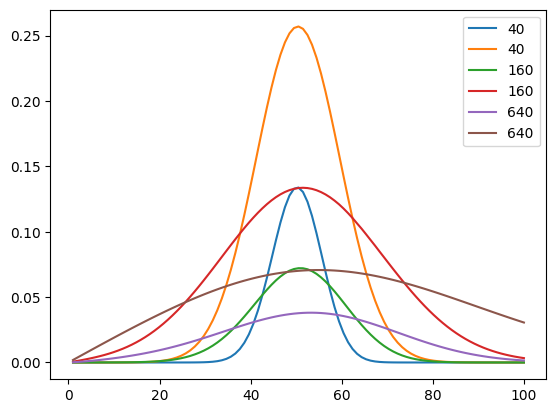

In [ ]:
ndof = 1
fe = FE(ndof)

a, b = 1, 100

griglia = GRID(a,b,100,ndof=ndof,getM=True,fe=fe)

alpha = -3/10
t = 10
eps = (b-a)/50*2
mu = (b+a)/2
mu = 50
grigliaconv = GRID((b+a)/2-2*eps,(b+a)/2+2*eps,5)

# condizione iniziale a supporto compatto
f0 = lambda x: nicekernel(x,mu,eps)

X = griglia.globV
u = f0(X)
ts = []

fig, ax = plt.subplots()

for k in tqdm(range(1,4)):
    y = 4**k
    Y = discexact(X,t*y,f0,grigliaconv,alpha=alpha,approx=True)
    Y0 = discexact(X,t*y,f0,grigliaconv,alpha=0,approx=True)
    ax.plot(X,Y,label=f"{t*y}")
    ax.plot(X,Y0,label=f"{t*y}")
ax.legend()
plt.show()